In [1]:
"""
In this example we demonstrate how to implement a DQN agent and
train it to trade optimally on a periodic price signal.
Training time is short and results are unstable.
Do not hesitate to run several times and/or tweak parameters to get better results.
Inspired from https://github.com/keon/deep-q-learning
"""
import random
import sys
sys.path.append('/Users/matthewdixon/Downloads/dq-MM/')
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from tgym.envs import SpreadTrading
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/matthewdixon/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [106]:
class DQNAgent:
    def __init__(self,
                 state_size,
                 action_size,
                 episodes,
                 episode_length,
                 memory_size=2000,
                 train_interval=100,
                 gamma=0.95,
                 learning_rate=0.001,
                 batch_size=64,
                 epsilon_min=0.01
                 ):
        self.state_size = state_size
        self.action_size = action_size
        self.memory_size = memory_size
        self.memory = [None] * memory_size
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_min = epsilon_min
        self.epsilon_decrement = (self.epsilon - epsilon_min)\
            * train_interval / (episodes * episode_length)  # linear decrease rate
        self.learning_rate = learning_rate
        self.train_interval = train_interval
        self.batch_size = batch_size
        self.brain = self._build_brain()
        self.i = 0

    def _build_brain(self):
        """Build the agent's brain
        """
        brain = Sequential()
        neurons_per_layer = 24
        activation = "relu"
        brain.add(Dense(neurons_per_layer,
                        input_dim=self.state_size,
                        activation=activation))
        brain.add(Dense(neurons_per_layer, activation=activation))
        brain.add(Dense(self.action_size, activation='linear'))
        brain.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return brain

    def act(self, state):
        """Acting Policy of the DQNAgent
        """
        action = np.zeros(self.action_size)
        valid_actions = []
        position = state[-3:]
        
        if all(position == [1,0,0]): # flat
            valid_actions = [0,1,2]
        elif all(position == [0,1,0]):  # long
            valid_actions = [0,2]  # hold or sell
        else: # short
            valid_actions = [0,1]  # hold or buy
        
        if np.random.rand() <= self.epsilon:    
            action[valid_actions[random.randrange(len(valid_actions))]] = 1   
        else:
            state = state.reshape(1, self.state_size)
            act_values = self.brain.predict(state)
            #print act_values[0]
            action[valid_actions[np.argmax(act_values[0][valid_actions])]] = 1
        return action

    def observe(self, state, action, reward, next_state, done, warming_up=False):
        """Memory Management and training of the agent
        """
        self.i = (self.i + 1) % self.memory_size
        self.memory[self.i] = (state, action, reward, next_state, done)
        if (not warming_up) and (self.i % self.train_interval) == 0:
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrement
            state, action, reward, next_state, done = self._get_batches()
            reward += (self.gamma
                       * np.logical_not(done)
                       * np.amax(self.brain.predict(next_state),
                                 axis=1))
            q_target = self.brain.predict(state)
            #print "state: ", state[0]
            #print "action[0]: ", action[0]
            #print "action[1]: ", action[1]
            #print "q_target: ", q_target[action[0], action[1]]
            #print "reward: ", reward
            
            q_target[action[0], action[1]] = reward
            return self.brain.fit(state, q_target,
                                  batch_size=self.batch_size,
                                  epochs=1,
                                  verbose=False)

    def _get_batches(self):
        """Selecting a batch of memory
           Split it into categorical subbatches
           Process action_batch into a position vector
        """
        batch = np.array(random.sample(self.memory, self.batch_size))
        state_batch = np.concatenate(batch[:, 0])\
            .reshape(self.batch_size, self.state_size)
        action_batch = np.concatenate(batch[:, 1])\
            .reshape(self.batch_size, self.action_size)
        reward_batch = batch[:, 2]
        next_state_batch = np.concatenate(batch[:, 3])\
            .reshape(self.batch_size, self.state_size)
        done_batch = batch[:, 4]
        # action processing
        action_batch = np.where(action_batch == 1)
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

In [105]:
import matplotlib.pyplot as plt
#import sys
#sys.path.append('/Users/matthewdixon/Downloads/Trading-Gym/')
#from tgym.envs import SpreadTrading
#from tgym.gens.deterministic import WavySignal
#from tgym.gens.random import AR1
from tgym.gens.csvstream import CSVStreamer
# Instantiating the environmnent
generator = CSVStreamer(filename='../data/AMZN-L1.csv')
#generator = AR1(a=0.1, ba_spread=0.1)   #WavySignal(period_1=25, period_2=50, epsilon=-0.5)
episodes = 100
episode_length = 400
trading_fee = .0
time_fee = 0
history_length = 2
environment = SpreadTrading(spread_coefficients=[1],
                            data_generator=generator,
                                trading_fee=trading_fee,
                                time_fee=time_fee,
                                history_length=history_length)

In [102]:
state = environment.reset()
# Instantiating the agent
memory_size = 3000
state_size = len(state)
gamma = 0.96
epsilon_min = 0.01
batch_size = 64
action_size = len(SpreadTrading._actions)
train_interval = 10
learning_rate = 0.001
agent = DQNAgent(state_size=state_size,
                     action_size=action_size,
                     memory_size=memory_size,
                     episodes=episodes,
                     episode_length=episode_length,
                     train_interval=train_interval,
                     gamma=gamma,
                     learning_rate=learning_rate,
                     batch_size=batch_size,
                     epsilon_min=epsilon_min)

In [103]:
# Warming up the agent
for _ in range(memory_size):
        action = agent.act(state)
        next_state, reward, done, _ = environment.step(action)
        agent.observe(state, action, reward, next_state, done, warming_up=True)
        
rews = []
losses = []
epsilons = []
# Training the agent
for ep in range(episodes):
    state = environment.reset()
    rew = 0
    for _ in range(episode_length):
        action = agent.act(state)
        
        for position in environment._positions:
          if all(environment._position==environment._positions[position]):
            position_name = position
        
    
        for _action in environment._actions:
          if all(action==environment._actions[_action]):
            action_name = _action
        
        next_state, reward, done, _ = environment.step(action)
        
        for position in environment._positions:
          if all(environment._position==environment._positions[position]):
            next_position_name = position
        
        
           
        #print position_name, action_name, next_position_name
        loss = agent.observe(state, action, reward, next_state, done)
        state = next_state
        rew += reward
    print("Ep:" + str(ep)
           + "| rew:" + str(round(rew, 2))
           + "| eps:" + str(round(agent.epsilon, 2))
           + "| loss:" + str(round(loss.history["loss"][0], 4)))
    rews.append(rew)
    epsilons.append(agent.epsilon)
    losses.append(loss.history["loss"][0])

[-1614.2766   259.9944  1560.3267]
[-968.71735   115.208725  676.751   ]
[-768.54614  156.22867  531.3052 ]
[-768.53314  154.577    530.10254]
[-1063.5344    355.69556  1164.2972 ]
[-490.92935  219.9465   345.1379 ]
[-339.80334  230.88425  259.27557]
[-300.0792   221.48132  236.31671]
[-298.92703  219.47346  234.68428]
[-263.3491   220.34482  203.0032 ]
[-196.79391  215.44624  174.33176]
[-643.70325  364.6928   879.065  ]
[-529.93054  367.23532  803.2838 ]
[-529.7739   346.93646  796.4288 ]
[-478.14557  359.29495  765.4579 ]
[ 16.931746 242.12386   77.22698 ]
[ -1.0915122 231.0158     70.317116 ]
[ 44.462944 234.21417   46.299534]
[ 34.92208 218.52374  49.66454]
[-314.50632  259.07666  617.5656 ]
[-256.92844  322.32834  573.8034 ]
[-204.61076  313.67435  539.8428 ]
[ 262.99448  232.8314  -103.668  ]
[ 303.33878   220.31445  -116.058304]
[ 303.60376  222.96992 -119.20332]
[-92.47566 305.70847 433.5396 ]
[-65.954346 346.2579   439.03528 ]
[-57.94802 299.7024  407.65805]
[ 369.90576  231.

[254.6904    54.253014  88.00538 ]
[253.39085  50.5067   86.51295]
[253.60275  50.45137  86.54161]
[253.38026   50.454197  86.591255]
[252.59874   30.956013  92.03665 ]
[251.4352   76.73456  73.62871]
[-14.528659    2.5096235  72.98269  ]
[260.12448   77.06353   89.979065]
[260.53824   61.2372    96.483284]
[255.41614   54.857117  90.296776]
[-3.45246  4.21754 73.1177 ]
[-9.077881  -6.3254876 77.55094  ]
[17.777374 25.895414 70.792366]
[265.43112   86.872925 108.45012 ]
[267.9401    76.54962  111.161545]
[268.60385  93.3721  106.31654]
[267.9597    76.53725  111.174805]
[268.96478  74.05029 112.7617 ]
[265.1487    50.789967 119.75941 ]
[256.43588  55.9754  135.51741]
[275.43387 101.8947  132.35594]
[281.0382    98.053825 132.88855 ]
[277.89505   91.563286 135.07718 ]
[278.60428  85.5704  134.6689 ]
[274.8786   77.92897 137.27818]
[36.002808 59.46593  62.664787]
[278.59756  85.56617 134.73808]
[35.91596  71.47973  55.440758]
[288.62778  93.43184 111.60275]
[272.04343  78.09026 103.43657

[228.62358   66.439026  88.75077 ]
[202.23755  99.36177 144.527  ]
[275.87985 116.45301 122.58691]
[228.8069   89.49863  97.59774]
[232.60861  94.06134  94.80891]
[229.94888  80.54634 100.16698]
[222.51443   60.971092 111.20059 ]
[218.43387  69.95559 106.94289]
[222.52246  77.41473 106.7881 ]
[225.02902  81.72599 110.73679]
[211.00168   53.006523  78.1652  ]
[205.29822  42.13102  93.35785]
[205.22786   51.040707  79.50608 ]
[209.97437  65.6941   96.43353]
[207.9646    39.681778 143.30739 ]
[189.03897   28.712357 152.94472 ]
[169.11957     6.4829907 151.53532  ]
[169.80067   15.825482 138.82959 ]
[187.10005   26.668133 156.41757 ]
[167.18042     4.4387326 155.00829  ]
[161.77673    8.155343 165.96024 ]
[176.31168  15.28251 175.84985]
[167.86525   13.787423 142.2719  ]
[189.63516   47.497566  87.19655 ]
[201.41112   41.087883  94.75552 ]
[193.87358   37.436844  98.8269  ]
[198.70192  47.60973  83.31452]
[204.63606   49.5839    82.091385]
[203.04759   59.41087   96.225685]
[-2.7702136 23.

[199.69801  84.76022  80.01086]
[200.02773  95.78178  93.71998]
[209.72586  106.67634   98.418144]
[211.24452 110.5689  101.92222]
[214.53699  95.0194   75.87477]
[183.31158  87.11031  91.50206]
[214.49713   95.151085  76.07591 ]
[177.90514   49.665344  91.7904  ]
[168.27293  56.1286   72.20643]
[176.84245  57.97332  73.86507]
[171.75189  77.57105 104.27914]
[210.7619   97.57732 102.46556]
[189.87378  78.59395  77.3098 ]
[196.65532  82.94585  77.22856]
[191.25282 106.08508 107.02905]
[217.95203  132.0752   118.604416]
[220.95088  135.1952   121.007324]
[223.09756 114.12871  86.97247]
[199.68748  85.3475   73.04028]
[179.80403   56.69374  105.267166]
[162.02284   53.38201  103.635414]
[164.5341    55.555283 100.72386 ]
[167.0382    53.136635  96.6435  ]
[169.7631    64.48771   56.428696]
[179.20844   66.55022   60.493378]
[175.99446   94.06163  100.101974]
[213.51859  129.87625  115.465706]
[216.2572  132.07767 117.05019]
[216.14604  133.89877  119.906395]
[222.13391 108.44308  78.12234

In [ ]:
plt.plot(epsilons)
plt.xlabel('episodes')
plt.ylabel('eps')
plt.savefig('epsilons.jpg')

In [ ]:
plt.plot(rews)
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.savefig('rewards.jpg')

[20.81069  75.89479  79.476746]
flat sell short
[192.71753  106.13866  118.627106]
short hold short
[194.92357  95.1293   98.77579]
short hold short
[167.19397  83.26781 109.89962]
short hold short
[193.84074 106.91522 118.10751]
short hold short
[194.94403   95.113914  98.81683 ]
short hold short
[165.08765   59.310696 104.55839 ]
short hold short
[156.48079   55.810658 105.860115]
short hold short
[154.02504  54.56989 104.18098]
short hold short
[156.48079   55.810658 105.860115]
short hold short
[154.02504  54.56989 104.18098]
short hold short
[154.69577   60.89822  114.207115]
short hold short
[168.14651   76.003494 116.886086]
short hold short
[174.38722   84.181526 102.88573 ]
short hold short
[181.52422  86.42606 100.33677]
short hold short
[181.52422  86.42606 100.33677]
short hold short
[181.52422  86.42606 100.33677]
short hold short
[181.52422  86.42606 100.33677]
short hold short
[181.52422  86.42606 100.33677]
short hold short
[182.06625   87.304474  98.88487 ]
short hold 

short hold short
[159.39769   56.519123  74.8107  ]
short hold short
[169.90778   62.075207  80.7403  ]
short hold short
[159.39745   56.519802  74.816895]
short hold short
[169.91354   62.079136  80.718864]
short hold short
[160.61116   53.059734  69.16075 ]
short hold short
[160.66156  52.93932  68.92976]
short hold short
[160.32985   52.630665  68.41347 ]
short hold short
[159.2046    50.777317  71.46637 ]
short hold short
[157.51126   50.569332  71.361046]
short hold short
[157.86023  50.89989  71.80371]
short hold short
[157.86023  50.89989  71.80371]
short hold short
[156.6455    54.362057  77.47898 ]
short hold short
[165.65178  64.10455  90.80412]
short hold short
[167.91911  66.57927  91.79151]
short hold short
[169.53069   61.782368  84.65055 ]
short hold short
[155.22704  54.09242  77.94614]
short hold short
[173.94225  76.33833  75.65941]
short hold short
[178.019     71.221375  85.59218 ]
short hold short
[169.64156  67.08432  91.25675]
short hold short
[168.2316   65.7278

[182.06209  77.6262   75.20578]
short hold short
[181.85622  72.7609   69.08551]
short hold short
[167.34987   60.794353  61.677776]
short hold short
[165.73659  75.49234  82.57347]
short hold short
[192.32285   90.14804   80.900955]
short hold short
[174.36574  67.36404  91.83639]
short hold short
[167.69238   68.019554  89.33806 ]
short hold short
[175.80057  77.11416  74.82112]
short hold short
[183.56728  78.62232  70.92351]
short hold short
[180.13852   74.281494  73.06531 ]
short hold short
[179.5912   75.60748  70.59654]
short hold short
[180.13852   74.281494  73.06531 ]
short hold short
[179.5912   75.60748  70.59654]
short hold short
[180.13852   74.281494  73.06531 ]
short hold short
[179.5912   75.60748  70.59654]
short hold short
[181.08485   75.840126  70.4827  ]
short hold short
[174.89539  66.2869   86.19916]
short hold short
[165.1506   61.78877  92.21281]
short hold short
[161.97319  65.59776  99.52567]
short hold short
[175.39288  74.2854   98.00578]
short hold short

[167.04816   59.01972   83.249054]
short hold short
[154.31606  52.57478  75.35315]
short hold short
[165.79558  63.61336  90.09068]
short hold short
[165.79558  63.61336  90.09068]
short hold short
[165.79558  63.61336  90.09068]
short hold short
[166.897    65.37261  87.18835]
short hold short
[167.58887  64.39864  89.06248]
short hold short
[166.25346   63.981724  89.53315 ]
short hold short
[166.25346   63.981724  89.53315 ]
short hold short
[165.1693    62.225018  92.4371  ]
short hold short
[164.65082  63.48142  90.09818]
short hold short
[165.1693    62.225018  92.4371  ]
short hold short
[163.56665   61.724735  93.00193 ]
short hold short
[163.59634   61.63789   92.867645]
short hold short
[164.13033   59.122166  89.27115 ]
short hold short
[157.40285   55.707104  84.794106]
short hold short
[169.41638  71.23657  76.17438]
short hold short
[179.38663   75.698     70.491486]
short hold short
[175.85216   67.90028   83.637436]
short hold short
[168.3091   65.55082  86.28715]
shor

[166.40063  61.62373  57.63448]
short hold short
[169.41092  63.16119  59.93352]
short hold short
[168.86823   61.595158  61.841526]
short hold short
[168.02298   61.910976  62.038586]
short hold short
[171.5593    66.649956  59.488277]
short hold short
[172.77196  63.94933  64.65063]
short hold short
[170.59468   63.373943  63.545574]
short hold short
[170.07927   62.453625  64.28111 ]
short hold short
[167.3524   56.27856  72.95974]
short hold short
[165.73604   63.727757  59.091686]
short hold short
[171.70488   64.60334   60.747967]
short hold short
[168.14482  60.91402  61.27728]
short hold short
[167.08066   61.173664  61.393238]
short hold short
[170.00932   63.44131   63.695545]
short hold short
[172.81758   64.574875  64.86131 ]
short hold short
[167.66948   55.922543  72.40688 ]
short hold short
[162.07716  54.0853   70.22604]
short hold short
[159.2735    50.683887  70.865845]
short hold short
[157.66565   50.496403  70.80263 ]
short hold short
[161.59569  60.99316  56.7008 

[166.41315   52.607372  73.16764 ]
short hold short
[156.6066    54.3281    77.108986]
short hold short
[167.06894   65.08687   86.538414]
short hold short
[168.40417   66.36788   87.182495]
short hold short
[170.81972   67.931656  86.90883 ]
short hold short
[168.40417   66.36788   87.182495]
short hold short
[170.81972   67.931656  86.90883 ]
short hold short
[168.40417   66.36788   87.182495]
short hold short
[175.63704  77.00187  74.40277]
short hold short
[178.08209   71.08764   85.407745]
short hold short
[172.0064    64.389725  81.36218 ]
short hold short
[160.44707   52.897114  68.83937 ]
short hold short
[160.39922   52.876163  68.847145]
short hold short
[160.46445  52.89931  68.84243]
short hold short
[160.44409   52.877033  68.876144]
short hold short
[160.51692  52.98859  68.64249]
short hold short
[160.6642    53.105335  68.49182 ]
short hold short
[159.52184  56.62662  74.24155]
short hold short
[170.17166  62.26952  80.1446 ]
short hold short
short hold short
[166.39679

[127.01019   30.927652 107.768074]
short hold short
[137.34459   36.147106 114.87749 ]
short hold short
[125.51027   35.20284  114.782234]
short hold short
[149.8276   67.65473 162.91646]
short hold short
[182.15044  99.68045 180.48378]
short hold short
[183.30426 100.92089 180.7265 ]
short hold short
[186.6008   93.70736 165.375  ]
short hold short


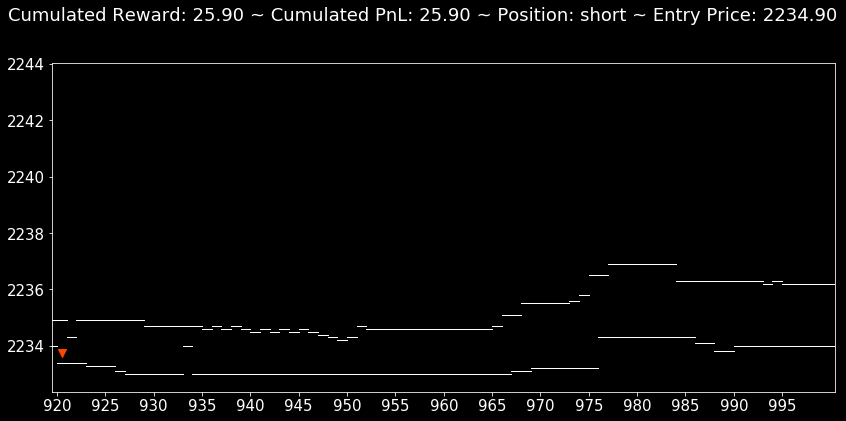

In [104]:
# Running the agent
done = False
state = environment.reset()
while not done:
    action = agent.act(state)
    
    for position in environment._positions:
          if all(environment._position==environment._positions[position]):
            position_name = position
        
    for _action in environment._actions:
          if all(action==environment._actions[_action]):
            action_name = _action
    
    state, _, done, info = environment.step(action)
    
    for position in environment._positions:
          if all(environment._position==environment._positions[position]):
            next_position_name = position
               
    print position_name, action_name, next_position_name
    
    if 'status' in info and info['status'] == 'Closed plot':
        done = True
    else:
        environment.render()